In [1]:
import findspark
findspark.init()
import pyspark as spark
from pyspark.sql.functions import udf
import pyspark.sql.functions as F
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sc = spark.SparkContext()
sql = spark.SQLContext(sc)

In [29]:
level = 1
label='primary_site'
L = 3
labels = ['primary_site', 'disease_type', 'disease_tissue']
#labels = ['primary_site', 'secondary_site']
algorithm = 'topsbm'
#labels = ['primary_site', 'secondary_site', 'status']
#labels=['RPPA Clusters']
directory = "/home/fvalle/phd/results/tcga/oversampling_10tissue"
#directory = "/Users/filippo/Google Drive File Stream/My Drive/tesi_magistrale/tesi/results/hSBM/highlyvariable_7tissues"
os.chdir(directory)

In [30]:
df_Pwt = sql.read.option('header',True).csv("%s/%s/%s_level_%d_word-dist.csv"%(directory,algorithm,algorithm,L))

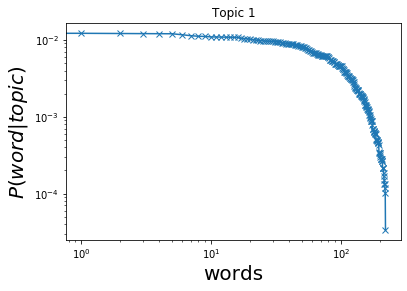

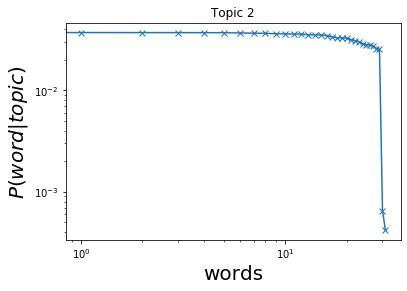

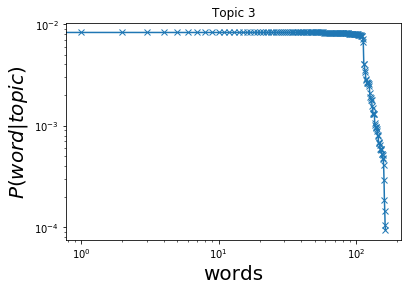

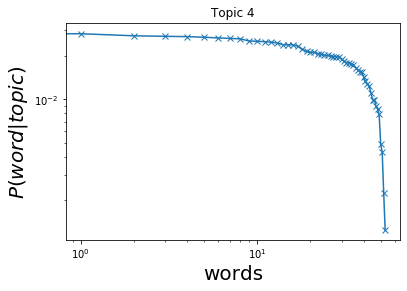

In [31]:
for topic in df_Pwt.columns[:5]:
    dist = df_Pwt.select([topic]).filter(F.col(topic)>1e-5).sort([topic], ascending=False).toPandas().astype(float).values
    if len(dist)<2:
        continue
    plt.title(topic)
    plt.plot(np.sort(dist[dist>0].T)[::-1], marker='x')
    plt.ylabel("$P(word | topic$)", fontsize=20)
    plt.xlabel("words", fontsize=20)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

In [32]:
df_Ptd = sql.read.option('header',True).csv("%s/%s/%s_level_%d_topic-dist.csv"%(directory,algorithm,algorithm,L)).drop('i_doc')

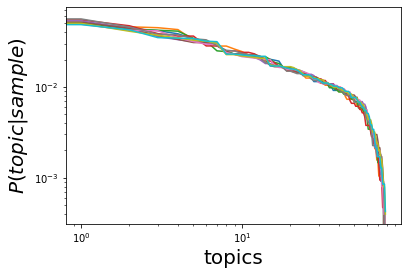

In [33]:
plt.figure()
plt.ylabel("$P(topic | sample$)", fontsize=20)
plt.xlabel("topics", fontsize=20)
for sample in df_Ptd.select('doc').toPandas().values[:10]:
    plt.plot(np.sort(df_Ptd.filter(F.col('doc')==sample[0]).drop('doc').toPandas().astype(float).values[0])[::-1])
plt.xscale('log')
plt.yscale('log')
plt.show()

In [34]:
import tensorflow as tf

In [35]:
Pgt = tf.convert_to_tensor(df_Pwt.toPandas().set_index('_c0').astype(float).values)
Pts = tf.transpose(tf.convert_to_tensor(df_Ptd.toPandas().set_index('doc').astype(float).values))

In [36]:
Pgt

<tf.Tensor 'Const_2:0' shape=(3739, 79) dtype=float64>

In [37]:
Pts

<tf.Tensor 'transpose_1:0' shape=(79, 793) dtype=float64>

In [38]:
with tf.Session() as sess:
    Pgs = sess.run(tf.matmul(Pgt,Pts))
Pgs.shape

(3739, 793)

In [39]:
df_Pgs = pd.DataFrame(data=Pgs, index=df_Pwt.select(['_c0']).toPandas().values.T[0], columns=df_Ptd.select(['doc']).toPandas().values.T[0])

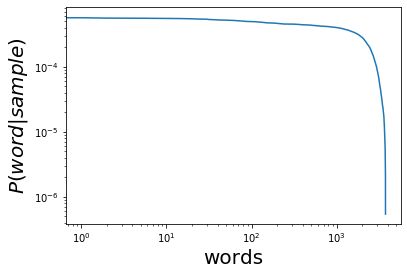

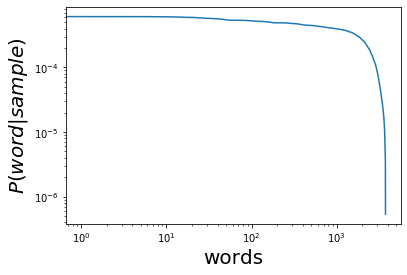

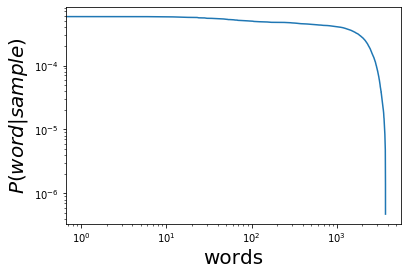

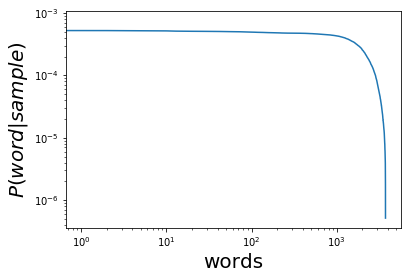

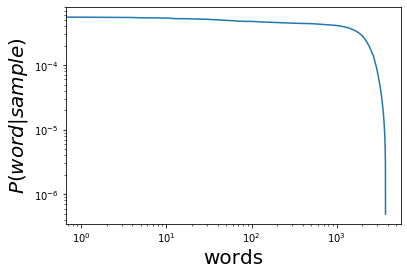

In [40]:
for doc in df_Pgs.columns[:5]:
    #doc = df_Pgs.columns[0]
    cdf = df_Pgs[doc]
    s_values = cdf[cdf>1e-95].sort_values(ascending=False)
    s_values = s_values/np.sum(s_values)
    plt.plot(s_values)
    plt.ylabel("$P(word | sample$)", fontsize=20)
    plt.xlabel("words", fontsize=20)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

In [41]:
s_values_hsbm=s_values

In [42]:
df_mt = sql.read.option("header",True).csv("%s/mainTable.csv"%directory)

In [43]:
abundancies = df_mt.toPandas().set_index('_c0').astype(int).sum(axis=1)

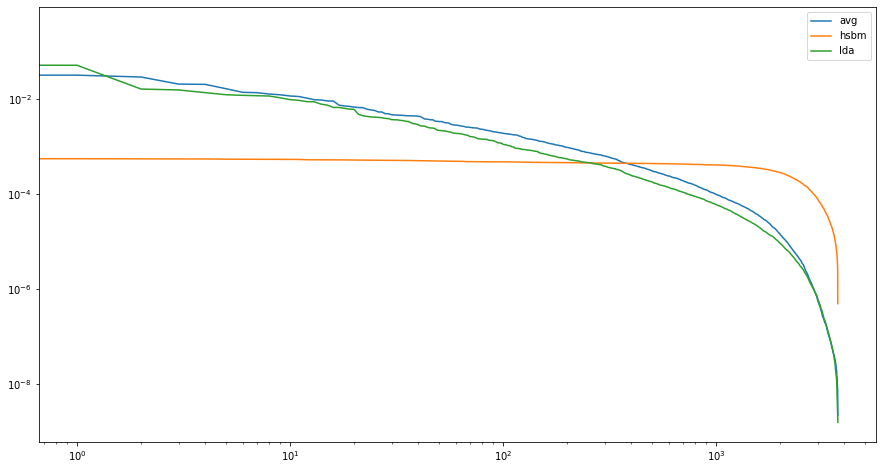

In [58]:
plt.figure(figsize=(15,8))
plt.plot(np.sort(abundancies.values)[::-1]/np.sum(abundancies), label='avg')
plt.plot(s_values_hsbm.values, label='hsbm')
plt.plot(s_values_lda.values, label='lda')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [56]:
s_values_hsbm.values

array([5.66418198e-04, 5.51789482e-04, 5.48310356e-04, ...,
       8.16949324e-07, 5.57358958e-07, 4.92126087e-07])

In [57]:
s_values_lda.values

array([3.27601755e-01, 5.10645214e-02, 1.61232679e-02, ...,
       1.69770491e-09, 1.66157816e-09, 1.57858535e-09])

In [55]:
s_values

ENSG00000128253    5.664182e-04
ENSG00000092051    5.517895e-04
ENSG00000075886    5.483104e-04
ENSG00000185303    5.460361e-04
ENSG00000166743    5.455271e-04
                       ...     
ENSG00000169800    1.968504e-06
ENSG00000280204    1.022102e-06
ENSG00000250745    8.169493e-07
ENSG00000226023    5.573590e-07
ENSG00000215269    4.921261e-07
Name: 00eb7c26-84fd-4ab9-93a1-, Length: 3736, dtype: float64